In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

In [137]:
class Solver:
    def __init__(self, ax, ay, bx, by, c, 
    left_border_condition, left_a, left_b, 
    right_border_condition, right_a, right_b, 
    bottom_border_condition, bottom_a, bottom_b, 
    top_border_condition, top_a, top_b, 
    left_border, right_border, bottom_border, top_border,
    nx, ny,
    end_time,
    time_steps,
    u_start) -> None:

        self.ax = ax
        self.ay = ay
        self.bx = bx
        self.by = by
        self.c = c
        self.left_border = left_border
        self.right_border = right_border
        self.top_border = top_border
        self.bottom_border = bottom_border

        self.lx = right_border-left_border
        self.ly = top_border-bottom_border

        self.nx = nx
        self.ny = ny

        self.hx = self.lx/(nx-1)
        self.hy = self.ly/(ny-1)

        self.end_time = end_time
        self.time_steps = time_steps
        self.tau = end_time/time_steps

        self.left_border_condition = left_border_condition
        self.right_border_condition = right_border_condition
        self.top_border_condition = top_border_condition
        self.bottom_border_condition = bottom_border_condition

        self.left_a = left_a
        self.left_b = left_b

        self.right_a = right_a
        self.right_b = right_b

        self.top_a = top_a
        self.top_b = top_b

        self.bottom_a = bottom_a
        self.bottom_b = bottom_b

        self.u_start = u_start

    def solve_variable_direction_method(self):
        ax = self.ax
        ay = self.ay
        bx = self.bx
        by = self.by
        c = self.c
        left_border = self.left_border
        right_border = self.right_border
        top_border = self.top_border
        bottom_border = self.bottom_border

        lx = self.right_border-left_border
        ly = self.top_border-bottom_border

        nx = self.nx
        ny = self.ny

        hx = self.hx
        hy = self.hy

        end_time = self.end_time
        time_steps = self.time_steps
        tau = self.tau

        left_border_condition = self.left_border_condition
        right_border_condition = self.right_border_condition
        top_border_condition = self.top_border_condition
        bottom_border_condition = self.bottom_border_condition

        left_a = self.left_a
        left_b = self.left_b

        right_a = self.right_a
        right_b = self.right_b

        top_a = self.top_a
        top_b = self.top_b

        bottom_a = self.bottom_a
        bottom_b = self.bottom_b

        u_start = self.u_start

        hist = np.zeros((ny, nx, 0))

        start = np.empty((ny, nx, 1))
        for y in range(ny):
            for x in range(nx):
                start[y, x] = u_start(left_border+hx*x, bottom_border+hy*y)

        hist = np.append(hist, start, 2)

        for k in range(0, time_steps):
            half_u = np.zeros((ny, nx, 1))
            next_u = np.zeros((ny, nx, 1))

            for y in range(1, ny-1):
                A = np.zeros((nx, nx))
                d = np.empty(nx)

                A[0, 0] = (-(left_a/hx)+left_b)
                A[0, 1] = (left_a/hx)
                A[-1, -1] = ((right_a/hx)+right_b)
                A[-1, -2] = -(right_a/hx)

                d[0] = left_border_condition(bottom_border+hy*y, tau*k+(tau/2))
                d[-1] = right_border_condition(bottom_border+hy*y, tau*k+(tau/2))

                for x in range(1, nx-1):
                    A[x, x-1] = -(ax/(hx**2))+bx/(2*hx)
                    A[x, x] = (2/tau)+((2*ax)/(hx**2))-c
                    A[x, x+1] = -(ax/(hx**2))-bx/(2*hx)
                    d[x] = (1/(tau/2))*hist[y, x, -1]+(ay/hy**2)*(hist[y+1, x, -1]-2*hist[y, x, -1]+hist[y-1, x, -1])+(by/(2*hy))*(hist[y+1, x, -1]-hist[y-1, x, -1])

                solution = np.linalg.solve(A, d)
                for x in range(nx):
                    half_u[y, x, 0] = solution[x]

            for x in range(nx):
                half_u[0, x, -1] = (bottom_border_condition(left_border+hx*x, tau*k+(tau/2))-(bottom_a/hy)*half_u[1, x, -1])/((-bottom_a/hy)+bottom_b)
                half_u[-1, x, -1] = (top_border_condition(left_border+hx*x, tau*k+(tau/2))+(top_a/hy)*half_u[-2, x, -1])/((top_a/hy)+top_b)

            for x in range(1, nx-1):
                A = np.zeros((ny, ny))
                d = np.empty(ny)

                A[0, 0] = (-(bottom_a/hy)+bottom_b)
                A[0, 1] = (bottom_a/hy)
                A[-1, -1] = ((top_a/hy)+top_b)
                A[-1, -2] = -(top_a/hy)

                d[0] = bottom_border_condition(left_border+hx*x, tau*k+tau)
                d[-1] = top_border_condition(left_border+hx*x, tau*k+tau)

                for y in range(1, ny-1):
                    A[y, y-1] = -(ay/(hy**2))+by/(2*hy)
                    A[y, y] = (2/tau)+((2*ay)/(hy**2))-c
                    A[y, y+1] = -(ay/(hy**2))-by/(2*hy)
                    d[y] = (1/(tau/2))*half_u[y, x, -1]+(ax/hx**2)*(half_u[y, x+1, -1]-2*half_u[y, x, -1]+half_u[y, x-1, -1])+(bx/(2*hx))*(half_u[y, x+1, -1]-half_u[y, x-1, -1])
                
                solution = np.linalg.solve(A, d)
                for y in range(ny):
                    next_u[y, x, 0] = solution[y]

            for y in range(ny):
                next_u[y, 0, -1] = (left_border_condition(bottom_border+hy*y, tau*k+tau)-(left_a/hx)*next_u[y, 1, -1])/((-left_a/hx)+left_b)
                next_u[y, -1, -1] = (right_border_condition(bottom_border+hy*y, tau*k+tau)+(right_a/hx)*next_u[y, -2, -1])/((right_a/hx)+right_b)

            hist = np.append(hist, next_u, 2)
        return hist

    def solve_fractional_step_method(self):
        ax = self.ax
        ay = self.ay
        bx = self.bx
        by = self.by
        c = self.c
        left_border = self.left_border
        right_border = self.right_border
        top_border = self.top_border
        bottom_border = self.bottom_border

        lx = self.right_border-left_border
        ly = self.top_border-bottom_border

        nx = self.nx
        ny = self.ny

        hx = self.hx
        hy = self.hy

        end_time = self.end_time
        time_steps = self.time_steps
        tau = self.tau

        left_border_condition = self.left_border_condition
        right_border_condition = self.right_border_condition
        top_border_condition = self.top_border_condition
        bottom_border_condition = self.bottom_border_condition

        left_a = self.left_a
        left_b = self.left_b

        right_a = self.right_a
        right_b = self.right_b

        top_a = self.top_a
        top_b = self.top_b

        bottom_a = self.bottom_a
        bottom_b = self.bottom_b

        u_start = self.u_start

        hist = np.zeros((ny, nx, 0))

        start = np.empty((ny, nx, 1))
        for y in range(ny):
            for x in range(nx):
                start[y, x] = u_start(left_border+hx*x, bottom_border+hy*y)

        hist = np.append(hist, start, 2)

        for k in range(1, time_steps):
            half_u = np.zeros((ny, nx, 1))
            next_u = np.zeros((ny, nx, 1))

            for y in range(1, ny-1):
                A = np.zeros((nx, nx))
                d = np.empty(nx)

                A[0, 0] = (-(left_a/hx)+left_b)
                A[0, 1] = (left_a/hx)
                A[-1, -1] = ((right_a/hx)+right_b)
                A[-1, -2] = -(right_a/hx)

                d[0] = left_border_condition(bottom_border+hy*y, tau*k)
                d[-1] = right_border_condition(bottom_border+hy*y, tau*k)

                for x in range(1, nx-1):
                    A[x, x-1] = (ax/(hx**2))-bx/(2*hx)
                    A[x, x] = (-1/tau)-(2*ax)/(hx**2)+c
                    A[x, x+1] = (ax/(hx**2))+bx/(2*hx)
                    d[x] = (-1/tau)*hist[y, x, -1]

                solution = np.linalg.solve(A, d)
                for x in range(nx):
                    half_u[y, x, 0] = solution[x]

            for x in range(nx):
                half_u[0, x] = (bottom_border_condition(left_border+hx*x, tau*k)-(bottom_a/hy)*half_u[1, x])/((-bottom_a/hy)+bottom_b)
                half_u[-1, x] = (top_border_condition(left_border+hx*x, tau*k)+(top_a/hy)*half_u[-2, x])/((top_a/hy)+top_b)

            for x in range(1, nx-1):
                A = np.zeros((ny, ny))
                d = np.empty(ny)

                A[0, 0] = (-(bottom_a/hy)+bottom_b)
                A[0, 1] = (bottom_a/hy)
                A[-1, -1] = ((top_a/hy)+top_b)
                A[-1, -2] = -(top_a/hy)

                d[0] = bottom_border_condition(left_border+hx*x, tau*k)
                d[-1] = top_border_condition(left_border+hx*x, tau*k)

                for y in range(1, ny-1):
                    A[y, y-1] = (ay/(hy**2))-by/(2*hy)
                    A[y, y] = (-1/tau)-(2*ay)/(hy**2)+c
                    A[y, y+1] = (ay/(hy**2))+by/(2*hy)
                    d[y] = (-1/tau)*half_u[y, x, -1]
                
                solution = np.linalg.solve(A, d)
                for y in range(ny):
                    next_u[y, x, 0] = solution[y]

            for y in range(ny):
                next_u[y, 0] = (left_border_condition(bottom_border+hy*y, tau*k)-(left_a/hx)*next_u[y, 1])/((-left_a/hx)+left_b)
                next_u[y, -1] = (right_border_condition(bottom_border+hy*y, tau*k)+(right_a/hx)*next_u[y, -2])/((right_a/hx)+right_b)

            hist = np.append(hist, next_u, 2)
        return hist

In [144]:
# вариант 5
true_a = 1
def true_u(x, y, t):
    return np.cos(2*x)*np.sinh(y)*np.exp(-3*true_a*t)

def u_start(x, y):
    return np.cos(2*x)*np.sinh(y)

left_border = 0
right_border = np.pi/2
bottom_border = 0
top_border = np.log(2)

def left_border_condition(y, t):
    return np.sinh(y)*np.exp(-3*true_a*t)
def right_border_condition(y, t):
    return -np.sinh(y)*np.exp(-3*true_a*t)
def bottom_border_condition(x, t):
    return np.cos(2*x)*np.exp(-3*true_a*t)
def top_border_condition(x, t):
    return (3/4)*np.cos(2*x)*np.exp(-3*true_a*t)

nx = 10
ny = 10

end_time = 10
time_steps = 20

solver = Solver(1, 1, 0, 0, 0,
left_border_condition, 0, 1,
right_border_condition, 0, 1,
bottom_border_condition, 1, 0,
top_border_condition, 0, 1,
left_border, right_border, bottom_border, top_border,
nx, ny,
end_time,
time_steps,
u_start)

In [139]:
# вариант 4
true_a = 1
def true_u(x, y, t):
    return np.cos(2*x)*np.cosh(y)*np.exp(-3*true_a*t)

def u_start(x, y):
    return np.cos(2*x)*np.cosh(y)

left_border = 0
right_border = np.pi/4
bottom_border = 0
top_border = np.log(2)

def left_border_condition(y, t):
    return np.cosh(y)*np.exp(-3*true_a*t)
def right_border_condition(y, t):
    return 0.0
def bottom_border_condition(x, t):
    return np.cos(2*x)*np.exp(-3*true_a*t)
def top_border_condition(x, t):
    return (3/4)*np.cos(2*x)*np.exp(-3*true_a*t)

nx = 10
ny = 10

end_time = 1
time_steps = 10

solver = Solver(1, 1, 0, 0, 0,
left_border_condition, 0, 1,
right_border_condition, 0, 1,
bottom_border_condition, 0, 1,
top_border_condition, 1, 0,
left_border, right_border, bottom_border, top_border,
nx, ny,
end_time,
time_steps,
u_start)

In [145]:
u = solver.solve_variable_direction_method()

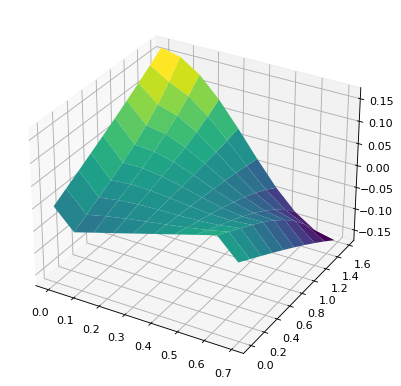

In [148]:
y = np.linspace(left_border, right_border, solver.nx)
x = np.linspace(bottom_border, top_border, solver.ny)
X, Y = np.meshgrid(x, y)
Z = u[:, :, 1]

plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

In [130]:
tu = np.empty((solver.nx, solver.ny, solver.time_steps))

for k in range(0, solver.time_steps):
    for x in range(solver.nx):
        for y in range(solver.ny):
            tu[y,x,k] = true_u(left_border+(x)*solver.hx, bottom_border+(y)*solver.hy, solver.tau*k)

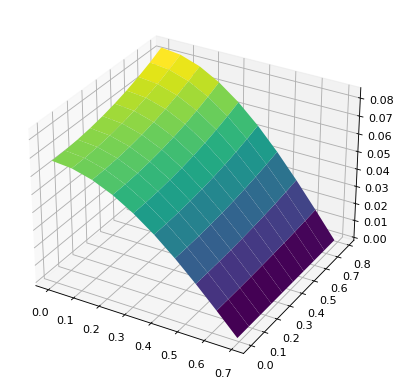

In [131]:
y = np.linspace(left_border, right_border, solver.nx)
x = np.linspace(bottom_border, top_border, solver.ny)
X, Y = np.meshgrid(x, y)
Z = tu[:, :, -1]

plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
